TODO
- 找到 range 与那些 feature 相关性比较高
- high 和 low 用平均波动标准化
- 统计价格到达上一高点（低点）时与后1个时刻内的最高（最低）涨（跌）幅，与上个振幅是否相关？再后面一个2个时刻内的最低（最高）多少
- MACD 用在 TR 上

# Init

In [32]:
from analysis_utils import get_combined_data
from utils import *
import pandas as pd
import numpy as np
from enum import Enum, auto
from typing import Dict, Optional, List, Set, TypeVar, Generic
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

usd_name = 'BUSD'
token_name='BTC'
symbol = token_name + usd_name

full_data = get_combined_data(symbol, 'default', 1652229060000, 1658229059999)

# Basic Functions

## Add targets

In [34]:
class Target:
    def __init__(self, target_step = 300, steps = [1, 3, 5, 10, 30, 100, 300]):
        self.target_step = target_step
        self.steps = steps
    
    def reset_target(self, target_step):
        self.target_step = target_step

    def name(self, step: int):
        return 'earn_after_{}'.format(step)

    def target_name(self):
        return self.name(self.target_step)
    
    def other_names(self):
        return [self.name(s) for s in self.steps if s != self.target_step]
    
    # Inplace
    def add_earns(self, data: pd.DataFrame):
        for step in self.steps:
            data['close_after_{}'.format(step)] = data['close'].shift(-step)
            data[earn_name(step)] = (data['close'].shift(-step) - data['close']) / data['close']
            data.drop('close_after_{}'.format(step), axis=1, inplace=True)
        
        return df

    # Inplace
    def drop_others(self, data: pd.DataFrame):
        data.drop(self.other_names(), axis=1, inplace=True)

# def earn_name(step: int):
#     return 'earn_after_{}'.format(step)

# def all_earn_names(target: int):
#     assert target in steps
#     others = [earn_name(s) for s in steps if s != target]
#     return earn_name(target), others

# def drop_other_steps(data: pd.DataFrame, target_step: int):
#     target_name, other_targets = all_earn_names(target_step)
#     data.drop(other_targets, axis=1, inplace=True)
#     return target_name

# # Return a copy with earn
# def add_earn(df_data: pd.DataFrame, steps) -> pd.DataFrame:
#     df = df_data.copy()
    
#     for step in steps:
#         df['close_after_{}'.format(step)] = df['close'].shift(-step)
#         df[earn_name(step)] = (df['close'].shift(-step) - df['close']) / df['close']
#         df.drop('close_after_{}'.format(step), axis=1, inplace=True)
    
#     return df

target = Target(300, [1, 3, 5, 10, 30, 100, 300])
df = full_data.copy()
df = target.add_earns(full_data)
print(target.target_name())
print(target.other_names())
df.head(10)

earn_after_300
['earn_after_1', 'earn_after_3', 'earn_after_5', 'earn_after_10', 'earn_after_30', 'earn_after_100']


,open_time,open,high,low,close,volume,close_time,quote_assert_volume,number_of_trades,taker_buy_volume,taker_buy_quote_asset_volume,TR,last_top,step_after_top,last_bottom,step_after_bottom,is_up,cycle_step,buy_price,sell_price,earn_after_1,earn_after_3,earn_after_5,earn_after_10,earn_after_30,earn_after_100,earn_after_300
0,1.652229e+12,31144.3,31165.8,31120.6,31164.2,30.906,1.652229e+12,9.624098e+05,501.0,18.305,569922.0360,45.2,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,-0.000562,-0.001258,0.000064,-0.000950,-0.005147,-0.011690,0.013050
1,1.652229e+12,31164.2,31180.0,31130.4,31146.7,27.177,1.652229e+12,8.468196e+05,427.0,10.484,326626.2207,49.6,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,-0.000999,-0.000093,-0.001082,-0.000530,-0.003477,-0.011144,0.016596
2,1.652229e+12,31140.6,31140.6,31100.0,31115.6,28.883,1.652229e+12,8.986365e+05,500.0,13.884,431899.1317,40.6,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.000302,0.001626,0.000363,0.002934,-0.002549,-0.009584,0.017914
3,1.652229e+12,31115.6,31154.9,31112.3,31125.0,19.850,1.652229e+12,6.179290e+05,398.0,9.091,282989.0656,42.6,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.000604,-0.000386,-0.001002,0.001960,-0.002847,-0.007409,0.014660
4,1.652229e+12,31123.2,31148.8,31117.9,31143.8,17.293,1.652229e+12,5.383497e+05,240.0,9.574,298012.8705,30.9,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.000719,-0.000543,-0.001878,-0.000212,-0.002925,-0.007998,0.014828
5,1.652229e+12,31143.8,31173.2,31140.1,31166.2,28.494,1.652229e+12,8.879296e+05,405.0,14.910,464567.9094,33.1,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,-0.001707,-0.002323,-0.001014,-0.001960,-0.004553,-0.009892,0.012860
6,1.652229e+12,31161.7,31178.0,31097.8,31113.0,31.265,1.652229e+12,9.733273e+05,501.0,15.006,467108.2783,80.2,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.000447,-0.000890,0.000553,-0.001051,-0.003985,-0.007672,0.013724
7,1.652229e+12,31113.7,31149.9,31103.6,31126.9,25.903,1.652230e+12,8.063249e+05,387.0,12.571,391250.2274,46.3,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,-0.001063,0.000247,0.002570,-0.001716,-0.006303,-0.006213,0.011485
8,1.652230e+12,31126.8,31133.1,31093.6,31093.8,19.994,1.652230e+12,6.220328e+05,363.0,8.712,271004.6069,39.5,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,-0.000273,0.001171,0.002965,-0.000650,-0.005261,-0.006525,0.013372
9,1.652230e+12,31094.4,31096.6,31058.2,31085.3,44.620,1.652230e+12,1.386531e+06,611.0,24.789,770227.8573,38.4,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.001586,0.003912,0.001670,-0.001589,-0.004430,-0.006489,0.012324


## 画图函数

In [14]:
# 画数据分布图
def histplot(pred, truth=None):
    plt.figure(figsize=(12,5))
    sns.histplot(pred, kde=True, color="blue")
    if truth:
        sns.histplot(truth, kde=True, color="red")
    plt.show()

# 画 B 相对于 A 的分布图，会把 A 等量分箱 50 份
def plt_A_B(df_data: pd.DataFrame, idx_A, idx_B, bias=0, cut=True, cut_num=50):
    plt.figure(figsize=(18,5))

    if cut:
        df_data[idx_A + '_cut'] = pd.qcut(df_data[idx_A], cut_num, duplicates='drop')
        idx_A = idx_A + '_cut'
        
    (df_data.groupby(idx_A)[idx_B].mean() - bias).plot.bar()
    plt.title(idx_B)
    plt.show()

    if cut:
        df_data.drop(idx_A, axis=1, inplace=True)

def plt_point_A_B(df_data, idx_A, idx_B):
    df_data.plot(kind='scatter', x=idx_A, y=idx_B, figsize=(18,5))

# 画 B 相对于 A 的分箱图，会把 A 等量分箱 50 份
def plt_box_A_B(df_data, idx_A, idx_B, cut=True, cut_num=50):
    plt.figure(figsize=(18,5))

    if cut:
        df_data[idx_A + '_cut'] = pd.qcut(df_data[idx_A], cut_num, duplicates='drop')
        idx_A = idx_A + '_cut'

    sns.boxplot(x=idx_A, y=idx_B, data=df_data)
    sns.stripplot(x=idx_A, y=idx_B, data=df_data)
    plt.title(idx_B)
    plt.show()

    if cut:
        df_data.drop(idx_A, axis=1, inplace=True)


def heatmap(pd_data):
    corrmat = pd_data.corr()
    f, ax = plt.subplots(figsize=(16, 12))
    sns.heatmap(corrmat, vmax=.8, square=True)

def heatmap_font(pd_data, k=-1, target=target_name):
    # k is the number of variables for heatmap
    if k == -1:
        k = pd_data.shape[1]
        
    corrmat = pd_data.corr()
    f, ax = plt.subplots(figsize=(20, 16))
    cols = corrmat.nlargest(k, target)[target].index
    cm = np.corrcoef(pd_data[cols].values.T)
    sns.set(font_scale=1.25) # type: ignore
    hm = sns.heatmap(cm,
                     cbar=True,
                     annot=True,
                     square=True,
                     fmt='.2f',
                     annot_kws={'size': 8}, 
                     yticklabels=cols.values,
                     xticklabels=cols.values)
    plt.show()

# histplot(df[target_name])
th = 0.03
print((sum(df[target_name] > th) + sum(df[target_name] < -th)) / len(df))

0.12213


# Add features

In [6]:
class FeatTypes(Enum):
    PRICE = 'close'
    VOLUME = 'quote_assert_volume'
    TRADE_NUM = 'number_of_trades'
    NO_STD = 'no_std'

class Features:
    def __init__(self, name: str, type: FeatTypes):
        self.name = name    # 10MA
        self.type = type    # FeatTypes.PRICE

    # Standardize feature in place of the input df_data
    def std(self, df_data: pd.DataFrame):
        # Don't divide itself
        if self.type != FeatTypes.NO_STD and self.name != self.type.value:
            df_data[self.name] = df_data[self.name].div(df_data[self.type.value], axis=0)
    
    def __str__(self):
        return self.name

new_ave_of_base = {
    'MA': ['close', FeatTypes.PRICE],
    'ATR': ['TR', FeatTypes.PRICE],
    # 'AQAV': ['quote_assert_volume', FeatTypes.VOLUME],
    # 'AT': ['number_of_trades', FeatTypes.TRADE_NUM],
    # 'ATBQAV': ['taker_buy_quote_asset_volume', FeatTypes.VOLUME],
    'ACS': ['cycle_step', FeatTypes.NO_STD]
    }

ave_features: Dict[str, Features] = {}

cycles = [3, 5, 10, 30, 100, 300]
for ave in new_ave_of_base:  
    for cc in cycles:
        name = ave + str(cc)
        [base, ftype] = new_ave_of_base[ave]
        df[name] = df[base].rolling(cc).mean()
        ave_features[name] = Features(name, ftype)
        
        k_name = name + '_k'
        df[k_name] = df[name] - df[name].shift(1)
        ave_features[k_name] = Features(k_name, ftype)

print(ave_features.keys())

# All features
all_features = ave_features
exist_feats = [ 
[['open', 'high', 'low', 'close', 'last_top', 'last_bottom', 'TR'], FeatTypes.PRICE],
[['number_of_trades'], FeatTypes.TRADE_NUM],
[['quote_assert_volume', 'taker_buy_quote_asset_volume'], FeatTypes.VOLUME],
]

for feats_type in exist_feats:
    feats, ftype = feats_type
    for f in feats:
        all_features[f] = Features(f, ftype)

print(all_features.keys())

df.tail(10)

dict_keys(['MA3', 'MA3_k', 'MA5', 'MA5_k', 'MA10', 'MA10_k', 'MA30', 'MA30_k', 'MA100', 'MA100_k', 'MA300', 'MA300_k', 'ATR3', 'ATR3_k', 'ATR5', 'ATR5_k', 'ATR10', 'ATR10_k', 'ATR30', 'ATR30_k', 'ATR100', 'ATR100_k', 'ATR300', 'ATR300_k', 'ACS3', 'ACS3_k', 'ACS5', 'ACS5_k', 'ACS10', 'ACS10_k', 'ACS30', 'ACS30_k', 'ACS100', 'ACS100_k', 'ACS300', 'ACS300_k'])
dict_keys(['MA3', 'MA3_k', 'MA5', 'MA5_k', 'MA10', 'MA10_k', 'MA30', 'MA30_k', 'MA100', 'MA100_k', 'MA300', 'MA300_k', 'ATR3', 'ATR3_k', 'ATR5', 'ATR5_k', 'ATR10', 'ATR10_k', 'ATR30', 'ATR30_k', 'ATR100', 'ATR100_k', 'ATR300', 'ATR300_k', 'ACS3', 'ACS3_k', 'ACS5', 'ACS5_k', 'ACS10', 'ACS10_k', 'ACS30', 'ACS30_k', 'ACS100', 'ACS100_k', 'ACS300', 'ACS300_k', 'open', 'high', 'low', 'close', 'last_top', 'last_bottom', 'TR', 'number_of_trades', 'quote_assert_volume', 'taker_buy_quote_asset_volume'])


,open_time,open,high,low,close,volume,close_time,quote_assert_volume,number_of_trades,taker_buy_volume,taker_buy_quote_asset_volume,TR,last_top,step_after_top,last_bottom,step_after_bottom,is_up,cycle_step,buy_price,sell_price,earn_after_1,earn_after_3,earn_after_5,earn_after_10,earn_after_30,earn_after_100,earn_after_300,MA3,MA3_k,MA5,MA5_k,MA10,MA10_k,MA30,MA30_k,MA100,MA100_k,MA300,MA300_k,ATR3,ATR3_k,ATR5,ATR5_k,ATR10,ATR10_k,ATR30,ATR30_k,ATR100,ATR100_k,ATR300,ATR300_k,ACS3,ACS3_k,ACS5,ACS5_k,ACS10,ACS10_k,ACS30,ACS30_k,ACS100,ACS100_k,ACS300,ACS300_k
99990,1.658228e+12,22000.1,22007.8,21977.8,21977.8,43.355,1.658229e+12,9.536830e+05,510.0,13.841,3.045368e+05,30.0,21953.4,98.0,21809.3,42.0,1.0,56.0,21977.8,NaN,-0.000419,0.000437,0.001101,NaN,NaN,NaN,NaN,21991.233333,-6.633333,21994.30,-7.00,21992.32,-6.85,21974.646667,3.943333,21914.842,1.357,21868.426000,-0.073000,19.833333,4.433333,22.60,-1.54,32.23,-0.25,32.933333,0.183333,27.005,0.271,30.692667,0.041667,56.0,0.0,56.0,0.0,56.0,0.0,79.8,-1.4,71.46,0.26,40.703333,0.146667
99991,1.658229e+12,21977.9,21992.1,21968.5,21968.6,51.141,1.658229e+12,1.124041e+06,575.0,13.711,3.013761e+05,23.6,21953.4,99.0,21809.3,43.0,1.0,56.0,21968.5,NaN,0.000901,0.000178,0.002454,NaN,NaN,NaN,NaN,21982.133333,-9.100000,21988.00,-6.30,21987.67,-4.65,21978.426667,3.780000,21915.369,0.527,21868.258000,-0.168000,21.933333,2.100000,19.96,-2.64,31.55,-0.68,33.560000,0.626667,26.492,-0.513,30.704333,0.011667,56.0,0.0,56.0,0.0,56.0,0.0,78.4,-1.4,71.72,0.26,40.850000,0.146667
99992,1.658229e+12,21968.6,21994.0,21968.6,21988.4,47.282,1.658229e+12,1.039419e+06,446.0,28.938,6.361075e+05,25.4,21953.4,100.0,21809.3,44.0,1.0,56.0,21968.6,NaN,-0.000045,0.000619,0.000864,NaN,NaN,NaN,NaN,21978.266667,-3.866667,21986.14,-1.86,21988.40,0.73,21983.260000,4.833333,21915.930,0.561,21868.144333,-0.113667,26.333333,4.400000,21.70,1.74,29.40,-2.15,33.963333,0.403333,26.370,-0.122,30.775667,0.071333,56.0,0.0,56.0,0.0,56.0,0.0,77.0,-1.4,71.98,0.26,40.996667,0.146667
99993,1.658229e+12,21988.5,21988.6,21979.6,21987.4,24.870,1.658229e+12,5.467337e+05,305.0,16.766,3.685595e+05,9.0,21953.4,101.0,21809.3,45.0,1.0,56.0,21979.6,NaN,-0.000678,0.001596,0.001651,NaN,NaN,NaN,NaN,21981.466667,3.200000,21984.44,-1.70,21991.19,2.79,21987.973333,4.713333,21916.702,0.772,21868.151333,0.007000,19.333333,-7.000000,20.04,-1.66,25.84,-3.56,34.173333,0.210000,26.237,-0.133,30.641667,-0.134000,56.0,0.0,56.0,0.0,56.0,0.0,75.6,-1.4,72.24,0.26,41.143333,0.146667
99994,1.658229e+12,21987.5,21987.5,21970.4,21972.5,22.142,1.658229e+12,4.866162e+05,310.0,1.785,3.923193e+04,17.1,21953.4,102.0,21809.3,46.0,1.0,56.0,21970.4,NaN,0.001343,0.001588,0.002608,NaN,NaN,NaN,NaN,21982.766667,1.300000,21978.94,-5.50,21990.12,-1.07,21992.160000,4.186667,21917.441,0.739,21868.100667,-0.050667,17.166667,-2.166667,21.02,0.98,22.58,-3.26,33.966667,-0.206667,26.122,-0.115,30.608667,-0.033000,56.0,0.0,56.0,0.0,56.0,0.0,74.2,-1.4,72.50,0.26,41.290000,0.146667
99995,1.658229e+12,21972.5,22006.9,21972.5,22002.0,48.459,1.658229e+12,1.065755e+06,526.0,31.333,6.890217e+05,34.4,21953.4,103.0,21809.3,47.0,1.0,56.0,21972.5,NaN,0.000932,0.000986,NaN,NaN,NaN,NaN,NaN,21987.300000,4.533333,21983.78,4.84,21989.04,-1.08,21996.746667,4.586667,21918.206,0.765,21868.239333,0.138667,20.166667,3.000000,21.90,0.88,22.25,-0.33,34.336667,0.370000,26.060,-0.062,30.535333,-0.073333,56.0,0.0,56.0,0.0,56.0,0.0,72.8,-1.4,72.76,0.26,41.436667,0.146667
99996,1.658229e+12,22002.1,22032.9,21992.8,22022.5,79.150,1.658229e+12,1.742416e+06,797.0,55.968,1.232091e+06,40.1,21953.4,104.0,21809.3,48.0,1.0,56.0,21992.8,NaN,-0.000686,0.000331,NaN,NaN,NaN,NaN,NaN,21999.000000,11.700000,21994.56,10.78,21991.28,2.24,22001.403333,4.656667,21919.101,0.895,21868.560333,0.321000,30.533333,10.366667,25.20,3.30,22.58,0.33,35.010000,0.673333,26.255,0.195,30.500333,-0.035000,56.0,0.0,56.0,0.0,56.0,0.0,71.4,-1.4,73.02,0.26,41.583333,0.146667
99997,1.658229e+12,22024.0,22025.9,22000.0,22007.4,43.500,1.658229e+12,9.575751e+

# 原始数据观测

In [7]:
# 显示数据缺失率，最大类别占比
def show_data_basic_info(pd_data, sort_target = 'Percentage of missing values'):
    stats = []
    for col in pd_data.columns:
        stats.append((col,
                      pd_data[col].nunique(),
                      pd_data[col].isnull().sum(),
                      pd_data[col].isnull().sum() * 100 / pd_data.shape[0],
                      pd_data[col].value_counts(normalize=True, dropna=False).values[0] * 100,
                      pd_data[col].dtype))

    stats_df = pd.DataFrame(stats, columns=['Feature',
                                            'Unique_values',
                                            'missing number',
                                            'Percentage of missing values',
                                            'Percentage of values in the biggest category',
                                            'type'])
    
    return stats_df.sort_values(sort_target, ascending=False)

In [8]:
columns = [value for value in df.columns if value not in ['open_time', 'buy_price', 'sell_price']]
df_trip = df.loc[:, columns].dropna()
show_data_basic_info(df_trip)[:10]

,Feature,Unique_values,missing number,Percentage of missing values,Percentage of values in the biggest category,type
0,open,50317,0,0.0,0.039293,float64
1,high,48589,0,0.0,0.039293,float64
32,MA100,98671,0,0.0,0.003023,float64
33,MA100_k,31727,0,0.0,0.027203,float64
34,MA300,98991,0,0.0,0.002015,float64
35,MA300_k,44980,0,0.0,0.023173,float64
36,ATR3,11818,0,0.0,0.070526,float64
37,ATR3_k,16727,0,0.0,0.305277,float64
38,ATR5,19272,0,0.0,0.042316,float64
39,ATR5_k,15679,0,0.0,0.324420,float64


# Standardization

In [9]:
full_buy = df_trip.copy()
full_buy.drop(['close_time', 'volume', 'taker_buy_volume'], axis=1, inplace=True)

# ['open', 'high', 'low', 'close', 'volume', 'quote_assert_volume',
# 'number_of_trades', 'taker_buy_volume', 'taker_buy_quote_asset_volume',
# 'TR', 'last_top', 'step_after_top', 'last_bottom', 'step_after_bottom',
# 'is_up', 'cycle_step', 'close_after_7', 'earn_after_7',
# 'close_after_30', 'earn_after_30', 'MA4', 'MA4_k', 'MA256', 'MA256_k',
# 'ATR4', 'ATR4_k', 'ATR256', 'ATR256_k', 'AQAV4', 'AQAV4_k', 'AQAV256',
# 'AQAV256_k', 'AT4', 'AT4_k', 'AT256', 'AT256_k', 'ATBQAV4', 'ATBQAV4_k',
# 'ATBQAV256', 'ATBQAV256_k', 'ACS4', 'ACS4_k', 'ACS256', 'ACS256_k']

# def withCycleK(name):
#     return [name+"{}{}".format(c, post) for c in cycles for post in ["", "_k"]]

# # atr_cols = ['TR'] + withCycleK('ATR')
# price_cols = ['open', 'high', 'low', 'close', 'last_top', 'last_bottom'] + withCycleK('MA') + ['TR'] + withCycleK('ATR')
# trade_cols = ['number_of_trades'] + withCycleK('AT')
# volumn_cols = ['quote_assert_volume', 'taker_buy_quote_asset_volume'] + withCycleK('AQAV') + withCycleK('ATBQAV')

# full_buy[atr_cols] = full_buy[atr_cols].div(full_buy['TR'], axis=0)
# full_buy[price_cols] = full_buy[price_cols].div(full_buy['close'], axis=0)
# full_buy[trade_cols] = full_buy[trade_cols].div(full_buy['number_of_trades'], axis=0)
# full_buy[volumn_cols] = full_buy[volumn_cols].div(full_buy['quote_assert_volume'], axis=0)

for feat in all_features.values():
    feat.std(full_buy)

full_buy.replace([np.inf, -np.inf], np.nan, inplace=True)
full_buy.dropna(axis=0, how='any', inplace=True)

# Drop the value which are always 1
full_buy.drop(['close', 'number_of_trades', 'quote_assert_volume'], axis=1, inplace=True)
full_buy.head(10)

,open,high,low,taker_buy_quote_asset_volume,TR,last_top,step_after_top,last_bottom,step_after_bottom,is_up,cycle_step,earn_after_1,earn_after_3,earn_after_5,earn_after_10,earn_after_30,earn_after_100,earn_after_300,MA3,MA3_k,MA5,MA5_k,MA10,MA10_k,MA30,MA30_k,MA100,MA100_k,MA300,MA300_k,ATR3,ATR3_k,ATR5,ATR5_k,ATR10,ATR10_k,ATR30,ATR30_k,ATR100,ATR100_k,ATR300,ATR300_k,ACS3,ACS3_k,ACS5,ACS5_k,ACS10,ACS10_k,ACS30,ACS30_k,ACS100,ACS100_k,ACS300,ACS300_k
446,0.998948,1.003185,0.998948,0.572697,0.004237,1.048045,165.0,1.020404,189.0,0.0,24.0,0.001696,0.004092,0.001042,0.002853,0.013443,0.036972,-0.042777,0.998678,0.000628,0.998173,0.000878,0.996738,0.000255,0.997821,-0.000207,1.008791,-0.000294,1.023155,-0.000110,0.003828,0.000371,0.003446,0.000365,0.002855,0.000027,0.003276,0.000096,0.002845,0.000023,0.002159,0.000007,24.0,0.0,24.0,0.0,24.0,0.0,24.0,0.0,24.0,0.0,27.113333,0.003333
447,0.998376,1.000285,0.998376,0.519242,0.001910,1.046271,166.0,1.018676,190.0,0.0,24.0,0.003540,0.000538,-0.002021,-0.000112,0.009486,0.036755,-0.042977,0.998522,0.001536,0.997477,0.000995,0.995723,0.000673,0.995989,-0.000143,1.006827,-0.000256,1.021313,-0.000110,0.003142,-0.000679,0.003298,-0.000142,0.002757,-0.000093,0.003281,0.000011,0.002835,-0.000005,0.002154,-0.000002,24.0,0.0,24.0,0.0,24.0,0.0,24.0,0.0,24.0,0.0,27.116667,0.003333
448,0.996387,1.000242,0.995334,0.606845,0.004908,1.042580,167.0,1.015083,191.0,0.0,24.0,-0.001144,-0.004179,-0.002985,0.000785,0.003943,0.032601,-0.043234,0.997086,0.002086,0.995376,0.001418,0.993154,0.000944,0.992472,-0.000003,1.003046,-0.000229,1.017616,-0.000094,0.003675,0.000544,0.003647,0.000360,0.003008,0.000260,0.003385,0.000115,0.002863,0.000038,0.002155,0.000009,24.0,0.0,24.0,0.0,24.0,0.0,24.0,0.0,24.0,0.0,27.120000,0.003333
449,1.001296,1.001876,0.999175,0.396328,0.002700,1.043774,168.0,1.016245,192.0,0.0,24.0,-0.001849,-0.004403,-0.002386,0.005892,0.006452,0.032563,-0.045813,0.999586,0.001358,0.997913,0.001396,0.995117,0.000825,0.993636,0.000027,1.003948,-0.000248,1.018686,-0.000096,0.003173,-0.000506,0.003404,-0.000247,0.003061,0.000049,0.003405,0.000016,0.002887,0.000020,0.002163,0.000005,24.0,0.0,24.0,0.0,24.0,0.0,24.0,0.0,24.0,0.0,27.123333,0.003333
450,1.001853,1.004473,1.000000,0.340683,0.004473,1.045708,169.0,1.018128,193.0,0.0,24.0,-0.001190,0.000007,0.000603,0.006631,0.005509,0.033761,-0.042957,1.001618,0.000179,1.000417,0.000655,0.997744,0.000783,0.995483,0.000006,1.005543,-0.000265,1.020458,-0.000115,0.004034,0.000855,0.003647,0.000237,0.003361,0.000294,0.003482,0.000071,0.002925,0.000033,0.002169,0.000002,24.0,0.0,24.0,0.0,24.0,0.0,24.0,0.0,24.0,0.0,27.126667,0.003333
451,1.001192,1.004065,0.999898,0.462265,0.004167,1.046954,170.0,1.019342,194.0,0.0,24.0,-0.001369,0.000653,0.001809,0.014010,0.009850,0.034363,-0.030597,1.001413,-0.001399,1.001818,0.000208,0.999476,0.000543,0.996653,-0.000016,1.006453,-0.000289,1.021552,-0.000122,0.003785,-0.000254,0.003639,-0.000013,0.003541,0.000176,0.003532,0.000046,0.002955,0.000026,0.002175,0.000004,24.0,0.0,24.0,0.0,24.0,0.0,24.0,0.0,24.0,0.0,27.130000,0.003333
452,1.001624,1.002075,0.999822,0.466556,0.002252,1.048390,171.0,1.020739,195.0,0.0,24.0,0.002571,0.003169,0.001913,0.013894,0.010449,0.036018,-0.033447,1.001312,-0.001474,1.002786,-0.000405,1.001142,0.000296,0.997958,-0.000062,1.007527,-0.000306,1.022818,-0.000134,0.003636,-0.000153,0.003711,0.000068,0.003508,-0.000037,0.003524,-0.000013,0.002970,0.000011,0.002175,-0.000003,24.0,0.0,24.0,0.0,24.0,0.0,24.0,0.0,24.0,0.0,27.133333,0.003333
453,0.997426,1.000282,0.995589,0.559569,0.004693,1.045701,172.0,1.018122,196.0,0.0,24.0,-0.000544,0.000610,0.003781,0.013996,0.009487,0.033410,-0.037204,0.998746,0.000002,0.999616,-0.000599,0.998986,0.000412,0.995508,0.000110,1.004662,-0.000282,1.020079,-0.000116,0.003700,0.000073,0.003656,-0.000046,0.003657,0.000158,0.003565,0.000051,0.003000,0.000037,0.002175,0.000005,24.0,0.0,24.0,0.0,24.0,0.0,24.0,0.0,24.0,0.0,27.136667,0.003333
454,1.000420,1.001736,0.999898,0.434209

# 观察特征

## 与未来波动范围 Range 的相关性

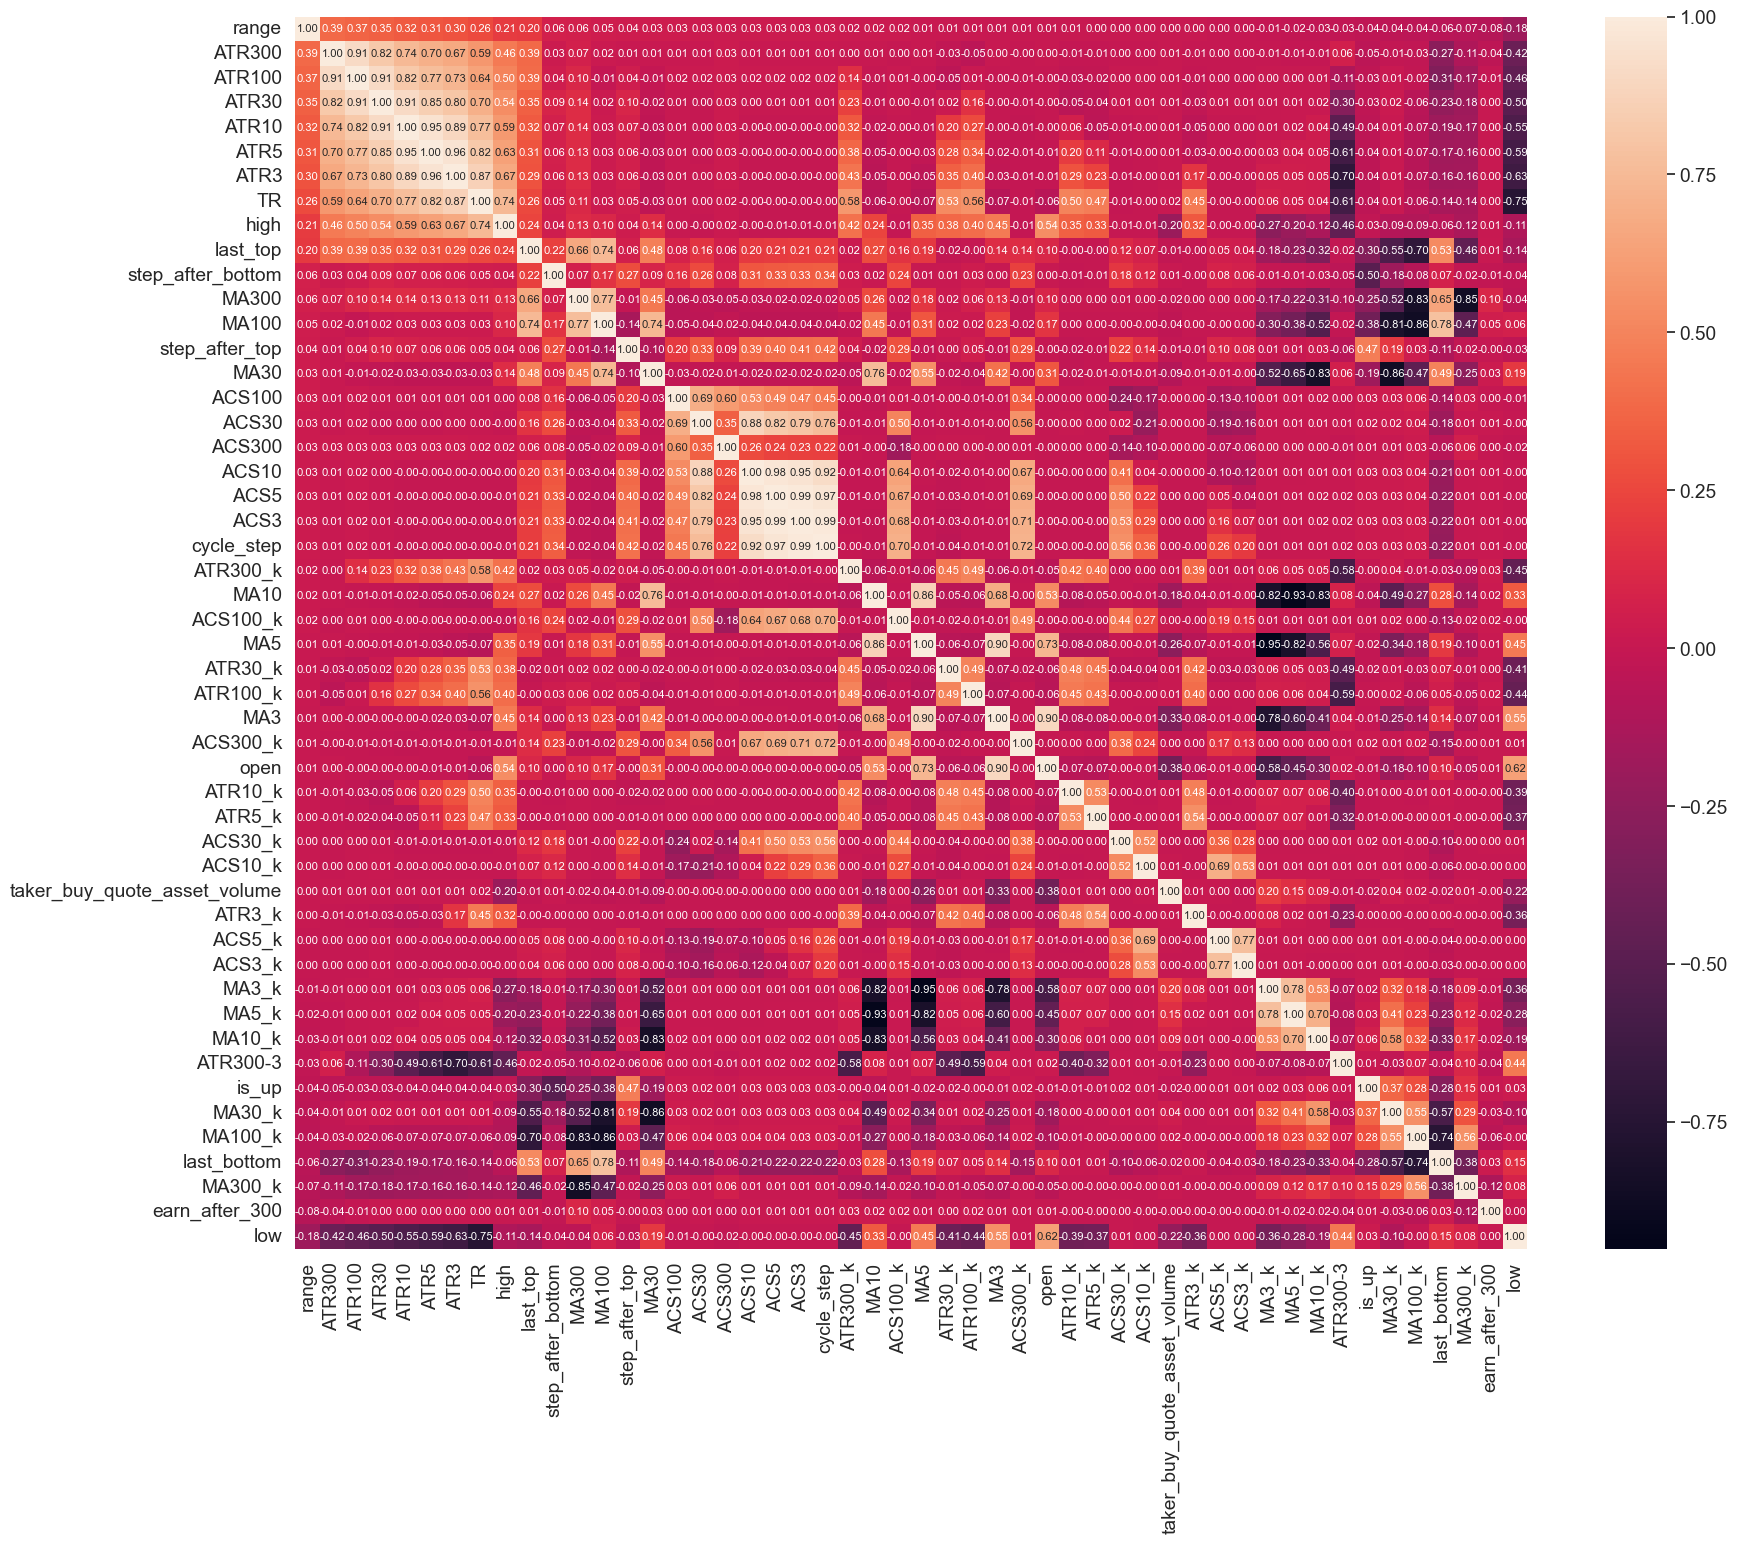

In [11]:
data_range = full_buy.copy()
# print(data_range.shape[1])
# th = 0.03
# key_data = data_range[data_range["range"]>th]
# key_data = data_range
# key_up_data = key_data[key_data["is_up"] == 1].drop("is_up", axis=1)
# key_up_data.head()
target = 300
data_range["ATR300-3"] = data_range["ATR300"] - data_range["ATR3"]
target_name = drop_other_steps(data_range, target)
data_range["range"] = data_range[target_name].apply(lambda x: x if x > 0 else -x)
heatmap_font(data_range, target="range")

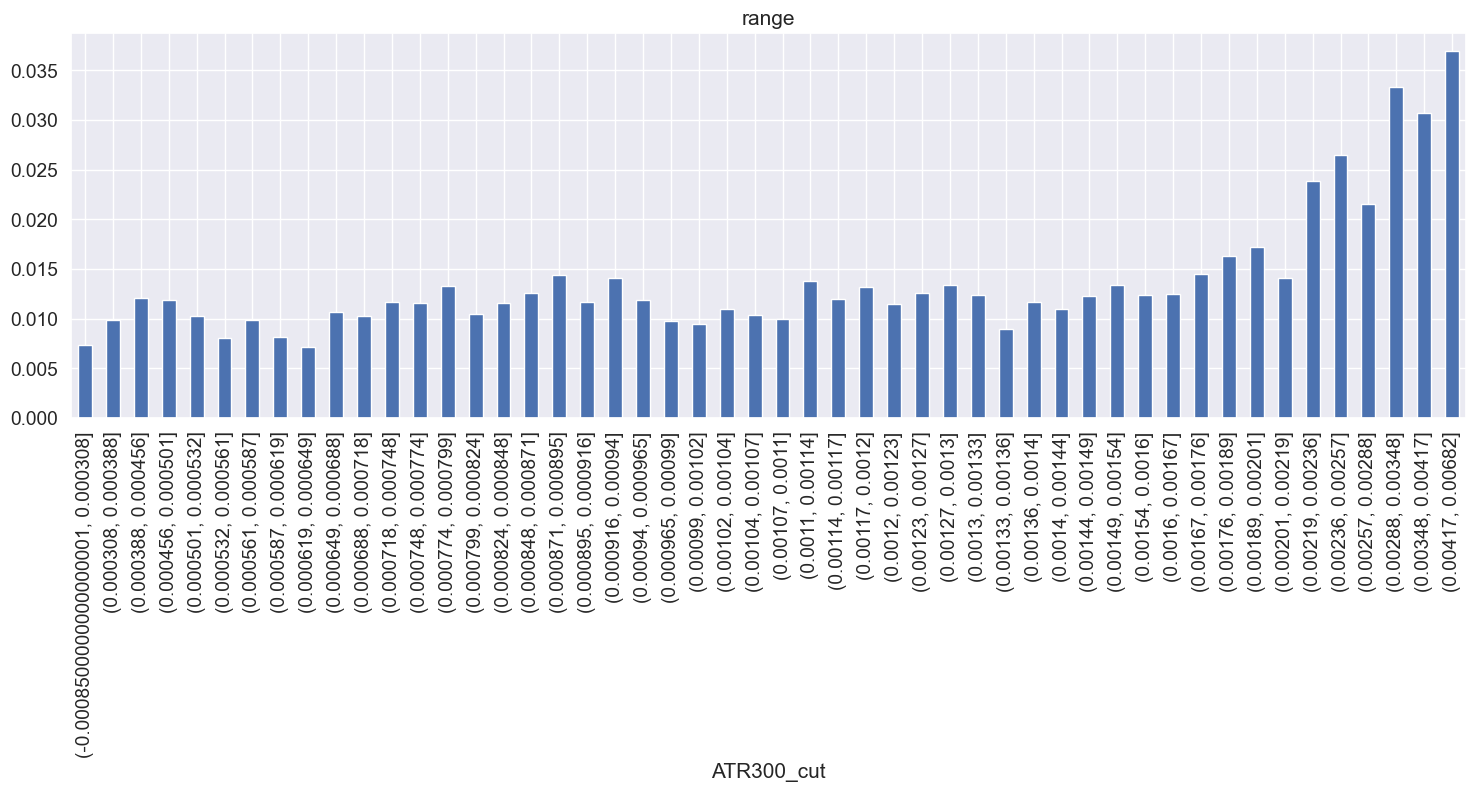

In [17]:
plt_A_B(data_range, "ATR300", "range")
# plt_box_A_B(data_range, "ATR300", "range")

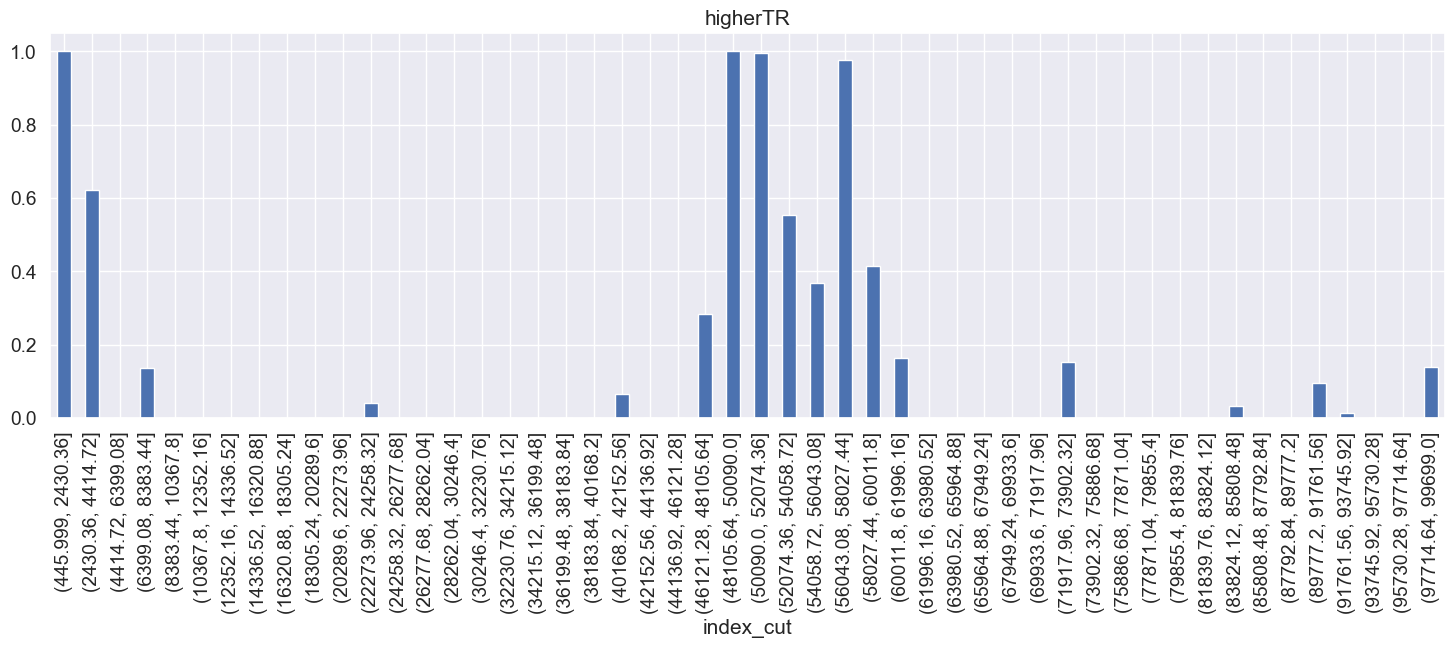

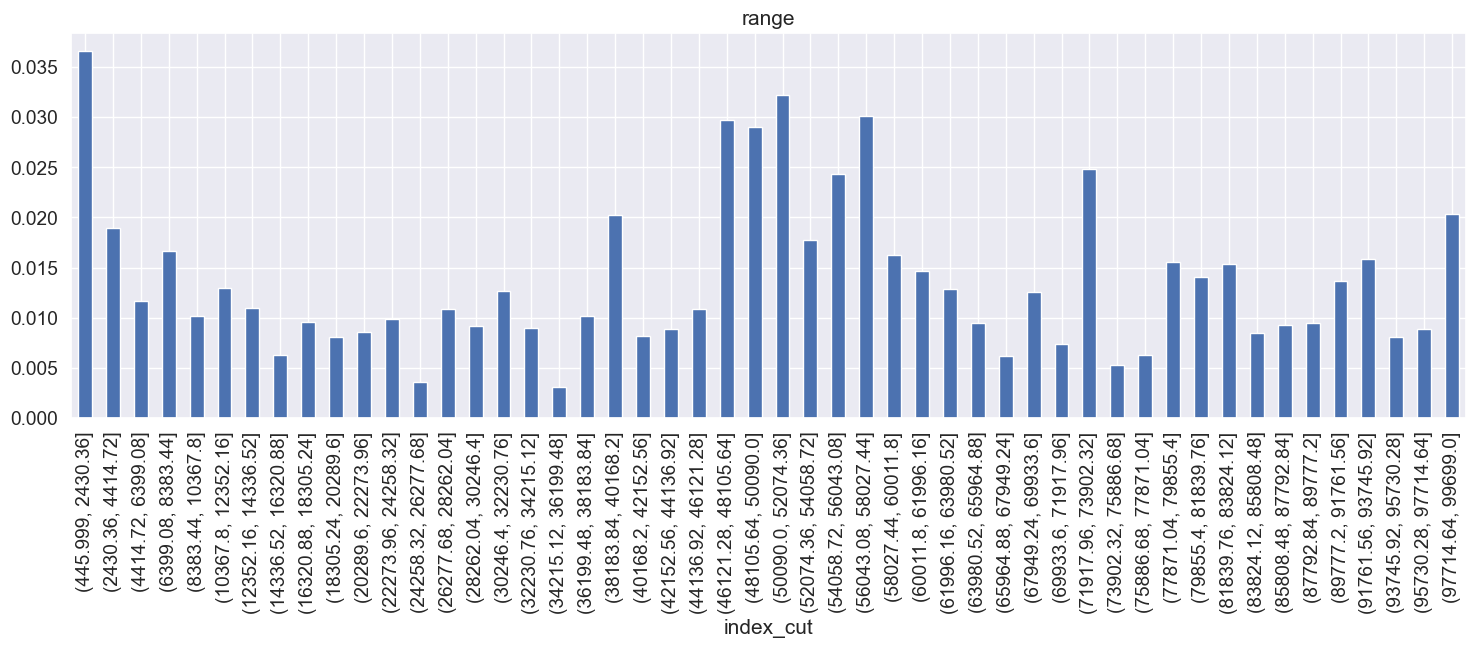

In [19]:
# full_buy[full_buy['high'] > 1.003].shape
data_range["index"] = data_range.index
data_range["higherTR"] = (data_range['ATR300'] > 0.002).apply(lambda x : 1 if x else 0)
plt_A_B(data_range, "index", "higherTR")
plt_A_B(data_range, "index", "range")

## 达到上一顶（底）价格后短期走势

In [31]:
data_top_bottom = full_buy.copy()
data_top_bottom['buy_price'] = df.loc[data_top_bottom.index, 'buy_price']

buy_break_data = data_top_bottom[pd.isna(data_top_bottom['buy_price'].shift(1)) & 
                                   (~pd.isna(data_top_bottom['buy_price']))].copy()

nonprice_cols = [col for col in full_buy.columns if col in all_features and all_features[col].type != FeatTypes.PRICE]
buy_break_data.drop(nonprice_cols, axis=1, inplace=True)

buy_break_data.head()

,open,high,low,TR,last_top,step_after_top,last_bottom,step_after_bottom,is_up,cycle_step,earn_after_1,earn_after_3,earn_after_5,earn_after_10,earn_after_30,earn_after_100,earn_after_300,MA3,MA3_k,MA5,MA5_k,MA10,MA10_k,MA30,MA30_k,MA100,MA100_k,MA300,MA300_k,ATR3,ATR3_k,ATR5,ATR5_k,ATR10,ATR10_k,ATR30,ATR30_k,ATR100,ATR100_k,ATR300,ATR300_k,buy_price
580,0.990392,1.002212,0.990392,0.011820,0.996350,299.0,0.943004,153.0,1.0,146.0,0.001187,0.000494,-0.004024,-0.005859,-0.008183,-0.015132,-0.015810,0.993221,0.004218,0.990720,0.002485,0.989775,0.000810,0.988093,0.000501,0.977977,4.195088e-04,0.971050,0.000030,0.005517,0.003431,0.004009,0.002106,0.002994,0.000759,0.002381,0.000329,0.002677,0.000079,0.002626,-0.000026,31887.3
854,0.996379,1.003366,0.996103,0.007263,1.000119,55.0,0.964305,34.0,1.0,21.0,-0.001999,-0.005242,-0.008565,-0.010061,-0.016975,-0.032486,-0.079505,0.996264,0.003625,0.993639,0.001788,0.991954,0.001588,0.983678,0.000994,0.961497,7.391960e-04,0.977361,0.000031,0.006498,0.001687,0.005118,0.000859,0.004858,0.000143,0.004875,0.000094,0.006556,0.000015,0.004447,0.000018,31820.8
1408,0.997743,1.000683,0.996421,0.004263,0.999596,51.0,0.984088,42.0,1.0,9.0,0.001346,0.002868,0.001716,0.001774,0.022850,0.013151,-0.045614,0.997845,0.001589,0.997307,0.000908,0.996841,0.000135,0.993938,0.000427,0.991768,1.725858e-07,0.998804,-0.000102,0.002580,0.000122,0.003014,0.000574,0.002514,0.000114,0.002902,0.000056,0.003189,0.000015,0.004307,0.000007,28959.4
1417,0.995755,1.000000,0.995334,0.004666,0.999368,60.0,0.983863,51.0,1.0,9.0,0.001546,0.001884,0.008603,0.005521,0.022856,0.019715,-0.060012,0.998246,-0.000240,0.999389,-0.000023,1.000586,0.000248,0.997367,0.000393,0.991737,6.480846e-05,0.997712,-0.000104,0.003304,0.000985,0.002873,0.000373,0.003381,0.000215,0.002938,0.000091,0.003240,-0.000006,0.004300,0.000006,28959.4
1801,0.999883,1.004490,0.997113,0.007377,1.001654,73.0,0.968166,38.0,1.0,35.0,-0.005778,-0.011922,-0.016806,-0.031217,-0.043858,0.015243,0.036882,0.996570,0.004223,0.992960,0.002305,0.988203,0.002222,0.983412,0.000852,0.986816,-2.014929e-05,1.024368,-0.000251,0.007889,0.000582,0.006700,0.000792,0.005560,0.000310,0.005230,0.000067,0.006055,0.000012,0.004820,0.000020,27440.8


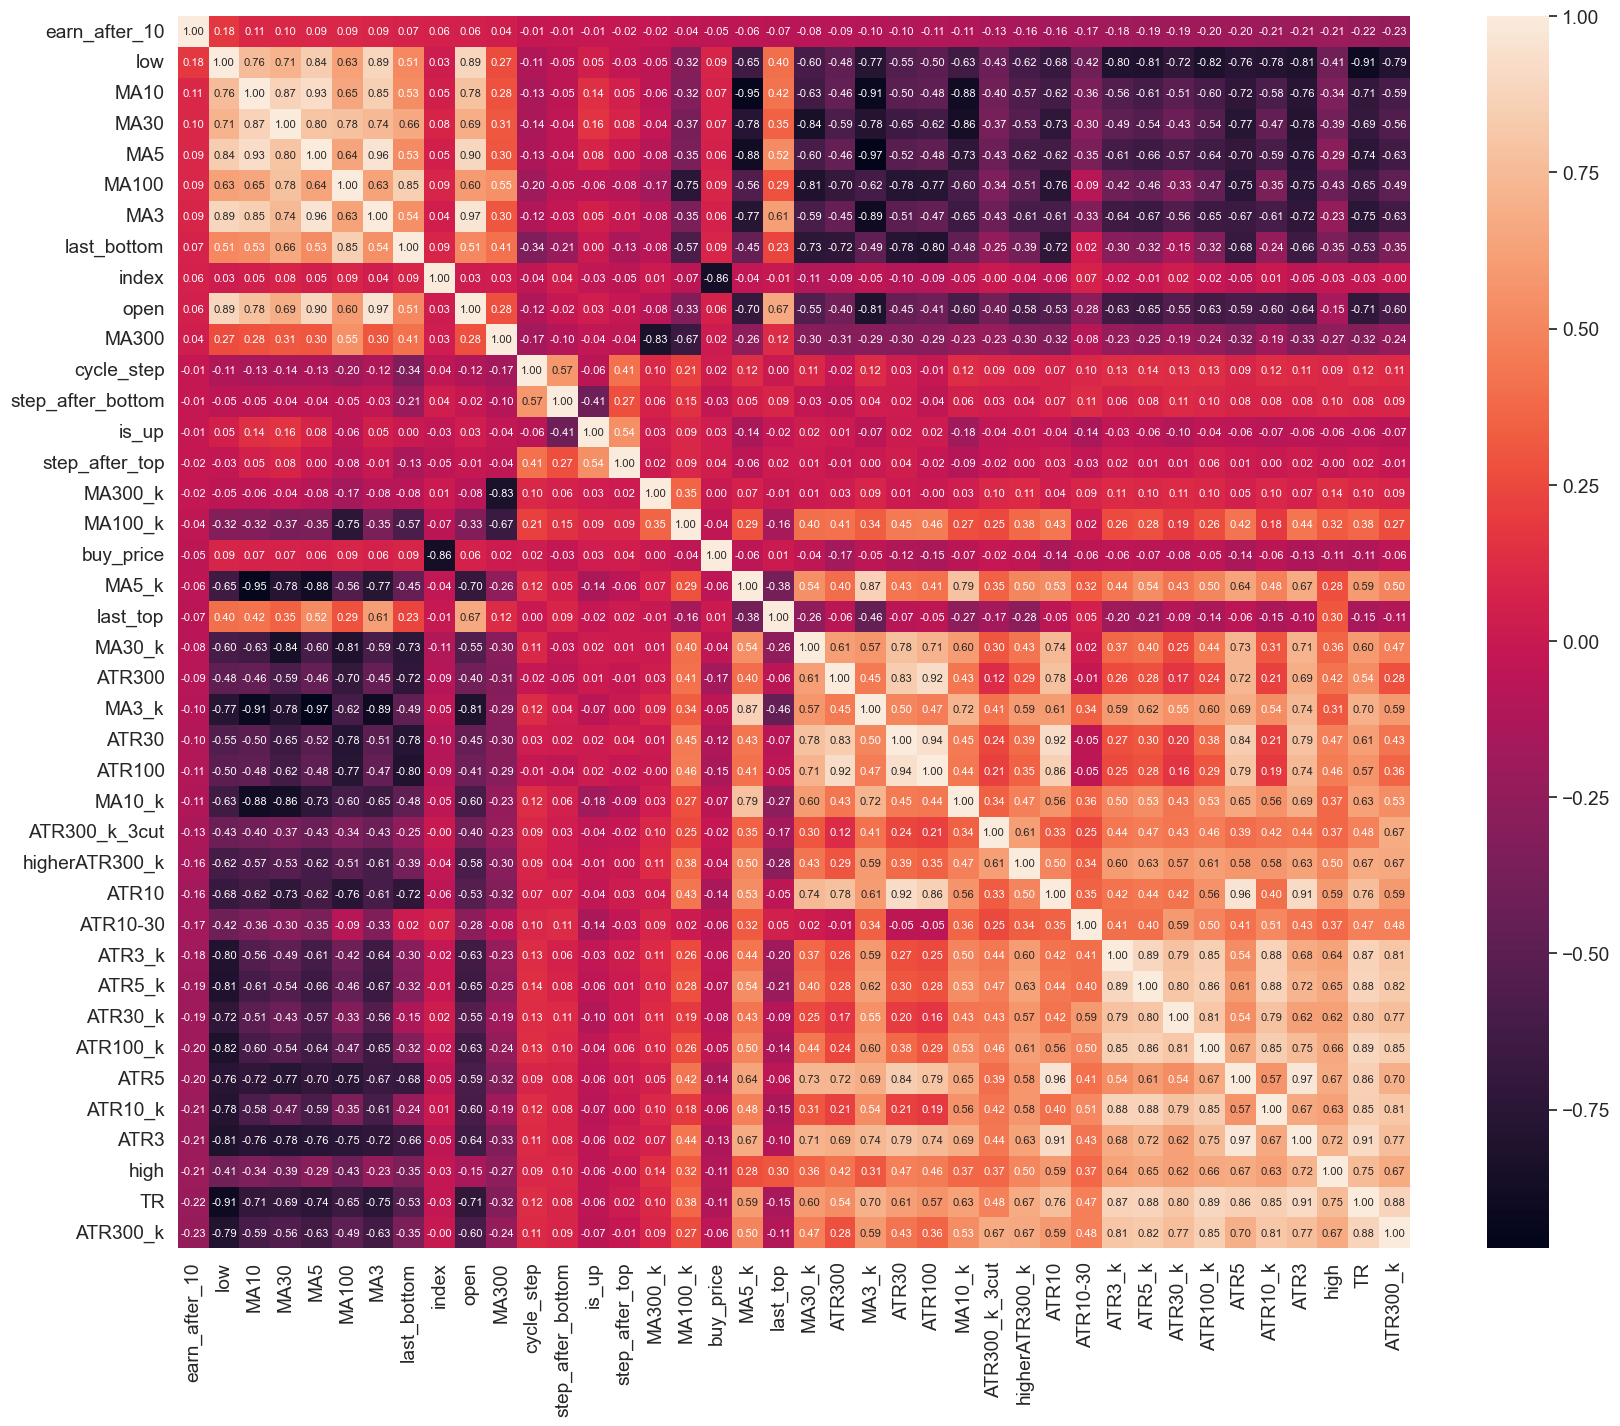

In [30]:
heatmap_data = buy_break_data.copy()
target = 10
# base = 1
# target_name = f'{target}-{base}'
# heatmap_data[target_name] = heatmap_data[earn_name(target)] - heatmap_data[earn_name(base)]
# drop_other_steps(heatmap_data, base)
target_name = drop_other_steps(heatmap_data, target)
heatmap_data['ATR10-30'] = heatmap_data['ATR10'] - heatmap_data['ATR30']
heatmap_font(heatmap_data, target=target_name)

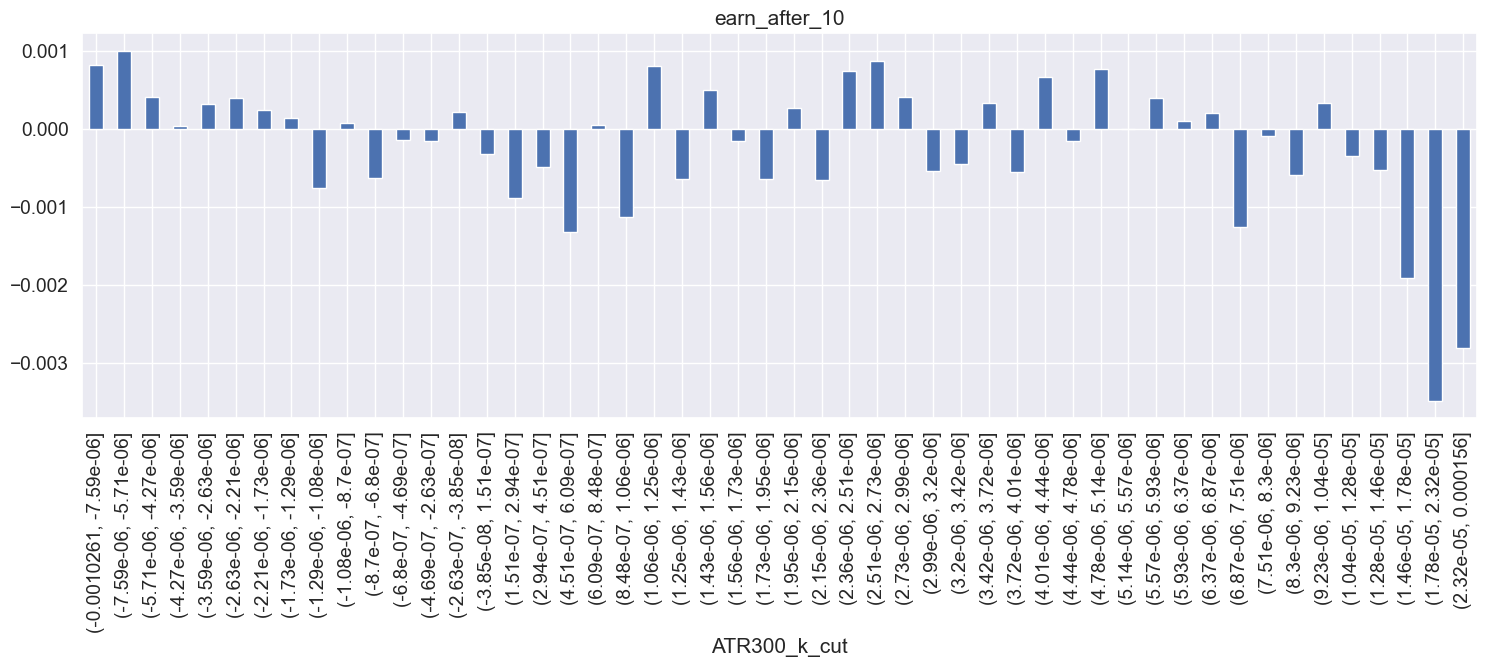

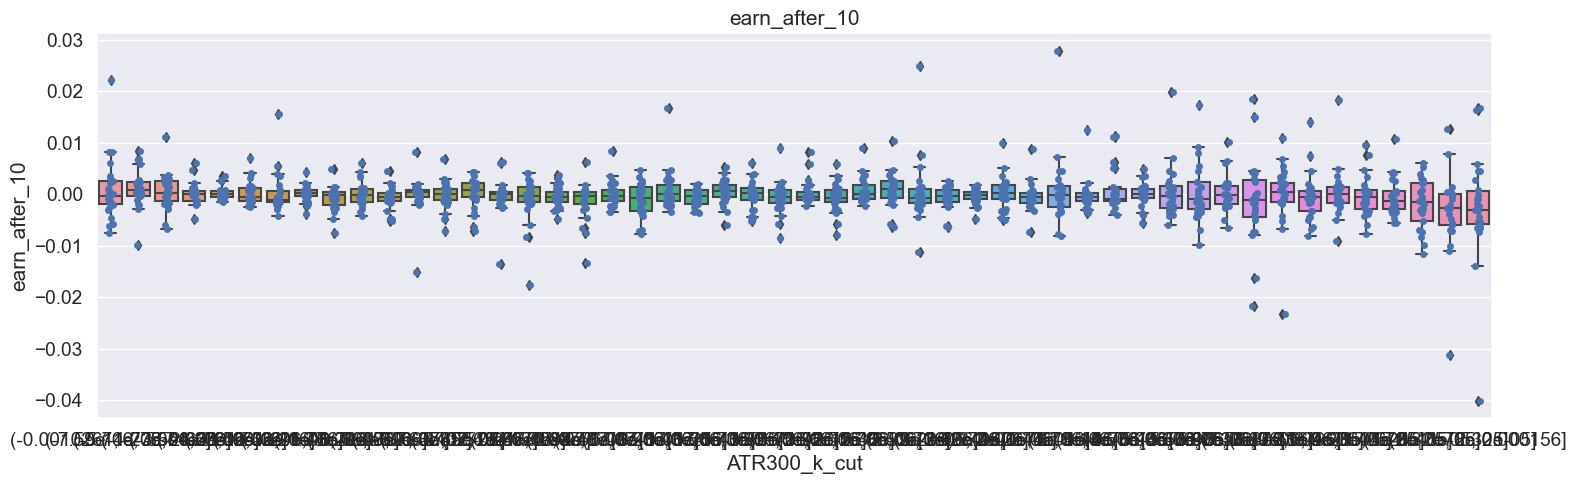

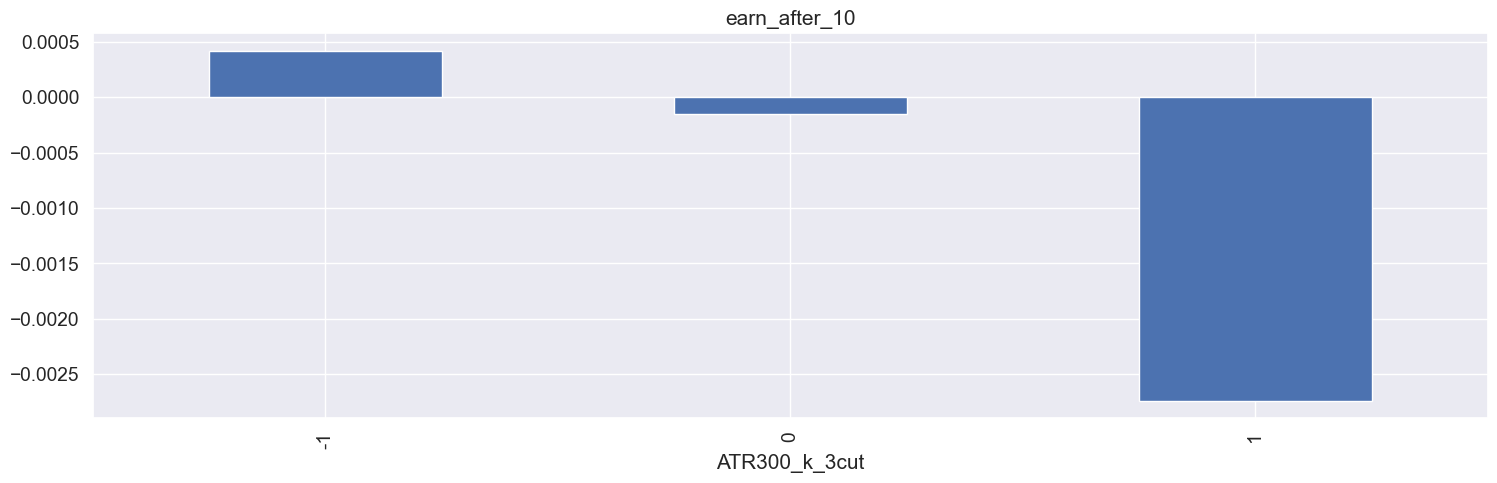

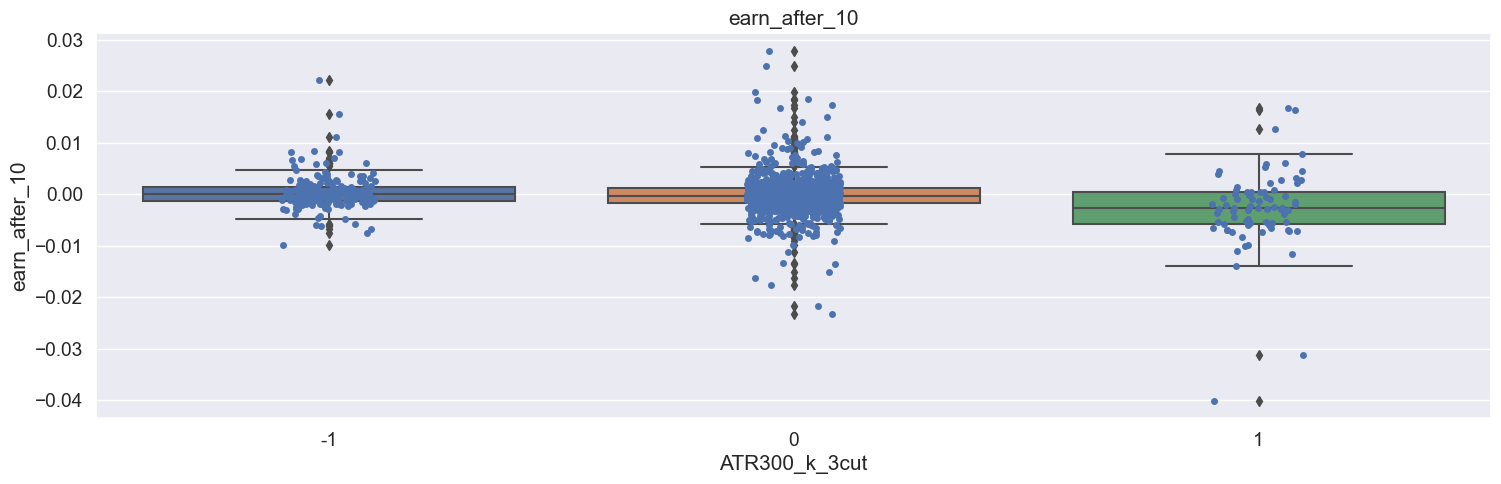

In [29]:
buy_break_data["index"] = buy_break_data.index
plt_A_B(buy_break_data, "ATR300_k", target_name)
plt_box_A_B(buy_break_data, "ATR300_k", target_name)
buy_break_data["ATR300_k_3cut"] = full_buy['ATR300_k'].apply(lambda x : 
                                                            1 if x > 1.46e-5 else
                                                            (-1 if x <-1.3e-6 else 0))
plt_A_B(buy_break_data, "ATR300_k_3cut", target_name, cut=False)
plt_box_A_B(buy_break_data, "ATR300_k_3cut", target_name, cut=False)
# plt_A_B(buy_break_data, 'index', 'ATR300_k_3cut')
# plt_A_B(buy_break_data, "index", target_name)

In [25]:
buy_break_data[buy_break_data[target_name] < -0.03]

,open,high,low,TR,last_top,step_after_top,last_bottom,step_after_bottom,is_up,cycle_step,earn_after_1,earn_after_3,earn_after_5,earn_after_10,earn_after_30,earn_after_100,earn_after_300,MA3,MA3_k,MA5,MA5_k,MA10,MA10_k,MA30,MA30_k,MA100,MA100_k,MA300,MA300_k,ATR3,ATR3_k,ATR5,ATR5_k,ATR10,ATR10_k,ATR30,ATR30_k,ATR100,ATR100_k,ATR300,ATR300_k,buy_price,index,higherATR300_k
1801,0.999883,1.00449,0.997113,0.007377,1.001654,73.0,0.968166,38.0,1.0,35.0,-0.005778,-0.011922,-0.016806,-0.031217,-0.043858,0.015243,0.036882,0.996570,0.004223,0.992960,0.002305,0.988203,0.002222,0.983412,0.000852,0.986816,-0.000020,1.024368,-0.000251,0.007889,0.000582,0.006700,0.000792,0.005560,0.000310,0.005230,0.000067,0.006055,0.000012,0.004820,0.000020,27440.8,1801,1
51449,0.998243,1.02020,0.971002,0.049198,1.018060,117.0,0.998466,160.0,0.0,43.0,-0.013547,-0.018732,-0.024793,-0.040097,-0.023235,0.033691,0.061941,0.997353,0.001237,0.997149,-0.001164,0.995366,0.001953,0.983797,0.000955,0.985163,-0.000091,1.002032,-0.000002,0.021386,0.013258,0.017674,0.007223,0.013063,0.004504,0.006512,0.001394,0.004305,0.000467,0.003408,0.000156,21500.0,51449,1


In [68]:
milliseconds_to_date(df.loc[51480, 'close_time'])

'2022-06-16 02:31:59.999000'

In [62]:
total_buy_bottom = len(buy_break_data)
for step in steps:
    print(f"{step}: {sum(buy_break_data[earn_name(step)] > 0) / total_buy_bottom * 100 :.2f} %")
    # histplot(buy_break_data[earn_name(step)])

1: 47.55 %
3: 45.09 %
5: 45.65 %
10: 44.86 %
30: 45.65 %
100: 46.36 %
300: 46.28 %


# ML

## 获得训练集与测试集

In [ ]:
def split_data(full: pd.DataFrame, percentage=0.8, target_name='target'):
    # 特征列名
    category_col = [col for col in full if col != target_name]
    end_rows = int(full.shape[0] * percentage)

    x_train = full[category_col][:end_rows].values.astype(np.float64)
    y_train = full[target_name][:end_rows].values.astype(np.float64)

    x_test = full[category_col][end_rows:].values.astype(np.float64)
    y_test = full[target_name][end_rows:].values.astype(np.float64)

    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = split_data(key_data, 0.5, target_name)

## xgb

In [ ]:
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

def xgb_predict(X_train, y_train, X_test, params=None, verbose_eval=100):
    
    if params == None:
        xgb_params = {'eta': 0.05, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 
                  'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'nthread': 4}
    else:
        xgb_params = params

    folds = KFold(n_splits=10, shuffle=True, random_state=2023)
    oof_xgb = np.zeros(len(X_train))
    predictions_xgb = np.zeros(len(X_test))

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
        if(verbose_eval):
            print("fold n°{}".format(fold_+1))
            print("len trn_idx  {}".format(len(trn_idx)))
            
        trn_data = xgb.DMatrix(X_train[trn_idx], y_train[trn_idx])
        val_data = xgb.DMatrix(X_train[val_idx], y_train[val_idx])

        watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
        clf = xgb.train(dtrain=trn_data,
                        num_boost_round=20000,
                        evals=watchlist,
                        early_stopping_rounds=200,
                        verbose_eval=verbose_eval,
                        params=xgb_params)
        
        
        oof_xgb[val_idx] = clf.predict(xgb.DMatrix(X_train[val_idx]), ntree_limit=clf.best_ntree_limit)
        predictions_xgb += clf.predict(xgb.DMatrix(X_test), ntree_limit=clf.best_ntree_limit) / folds.get_n_splits()

    if(verbose_eval):
        print("CV RMSE score: {:<8.8f}".format(sqrt(mean_squared_error(oof_xgb, y_train))))
    return oof_xgb, predictions_xgb

## lgb

In [ ]:
import lightgbm as lgb

def lgb_predict(X_train, y_train, X_test, params=None, verbose_eval=500):
    
    if params == None:
        lgb_param = {'num_leaves': 20, 'min_data_in_leaf': 2, 'objective':'regression', 'max_depth': 4,
         'learning_rate': 0.06, "min_child_samples": 2, "boosting": "gbdt", "feature_fraction": 1,
         "bagging_freq": 1, "bagging_fraction": 1, "bagging_seed": 11, "metric": 'rmse', "lambda_l2": 0.003,
         "verbosity": -1}
    else :
        lgb_param = params
        
    folds = KFold(n_splits=2, shuffle=True, random_state=2023)
    oof_lgb = np.zeros(len(X_train))
    predictions_lgb = np.zeros(len(X_test))

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
        if verbose_eval:
            print("fold n°{}".format(fold_+1))
            
        trn_data = lgb.Dataset(X_train[trn_idx], y_train[trn_idx])
        val_data = lgb.Dataset(X_train[val_idx], y_train[val_idx])

        num_round = 50000
        clf = lgb.train(lgb_param, trn_data, num_round, valid_sets = [trn_data, val_data],
                        verbose_eval=verbose_eval, early_stopping_rounds = 100)
        
        oof_lgb[val_idx] = clf.predict(X_train[val_idx], num_iteration=clf.best_iteration)

        predictions_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.get_n_splits()

    if verbose_eval:
        print("CV RMSE score: {:<8.8f}".format(sqrt(mean_squared_error(oof_lgb, y_train))))
    
    return oof_lgb, predictions_lgb

In [ ]:
oof_xgb, predictions_xgb = lgb_predict(x_train, y_train, x_test, verbose_eval=5000)

print("-"*100, end="\n\n")
print("CV normal RMSE scores of predicting {} \nis {:<8.8f}".
        format(col, sqrt(mean_squared_error(predictions_xgb, y_test))))

fold n°1
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=2 will be ignored. Current value: min_data_in_leaf=2
Training until validation scores don't improve for 100 rounds


e:\Python\Lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
e:\Python\Lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[5000]	training's rmse: 0.00122561	valid_1's rmse: 0.00318988
Early stopping, best iteration is:
[9206]	training's rmse: 0.000643509	valid_1's rmse: 0.00309466
fold n°2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=2 will be ignored. Current value: min_data_in_leaf=2
Training until validation scores don't improve for 100 rounds
[5000]	training's rmse: 0.00124362	valid_1's rmse: 0.00328022
[10000]	training's rmse: 0.000584177	valid_1's rmse: 0.0031775
Early stopping, best iteration is:
[14874]	training's rmse: 0.00031286	valid_1's rmse: 0.00315646
CV RMSE score: 0.00312571
----------------------------------------------------------------------------------------------------

CV normal RMSE scores of predicting ['open', 'high', 'low', 'close', 'last_top', 'step_after_top', 'last_bottom', 'step_after_bottom', 'is_up', 'cycle_step', 'buy_price', 'sell_price', 'earn_after_7'] 
is 0.00736146


In [ ]:
np.std(y_test)

0.0064567919468269085

In [ ]:
buy_i = [i for i in range(len(y_test)) if predictions_xgb[i] > 0.02] 
sell_i = [i for i in range(len(y_test)) if predictions_xgb[i] < -0.02]

In [ ]:
check_idx = sell_i
print(check_idx)
print(y_test[check_idx])
sum(y_test[check_idx]) / len(y_test)

[1512, 5770, 5771, 5772, 5774, 5775, 5786, 5787, 5788, 5789, 5790, 5791, 5792, 5813, 5814, 5815, 5816]
[-0.0135893  -0.00558362 -0.01311941  0.00090135 -0.00864617 -0.00413573
 -0.00397105 -0.00263351 -0.00735933 -0.00652635 -0.00398621  0.00291498
  0.00639329  0.02737069  0.03012378  0.02860306  0.02525206]


1.0450827972846964e-06

# 结果可视化

## 预测与实际结果对应关系

+ __画 A 与 B 的统计图__

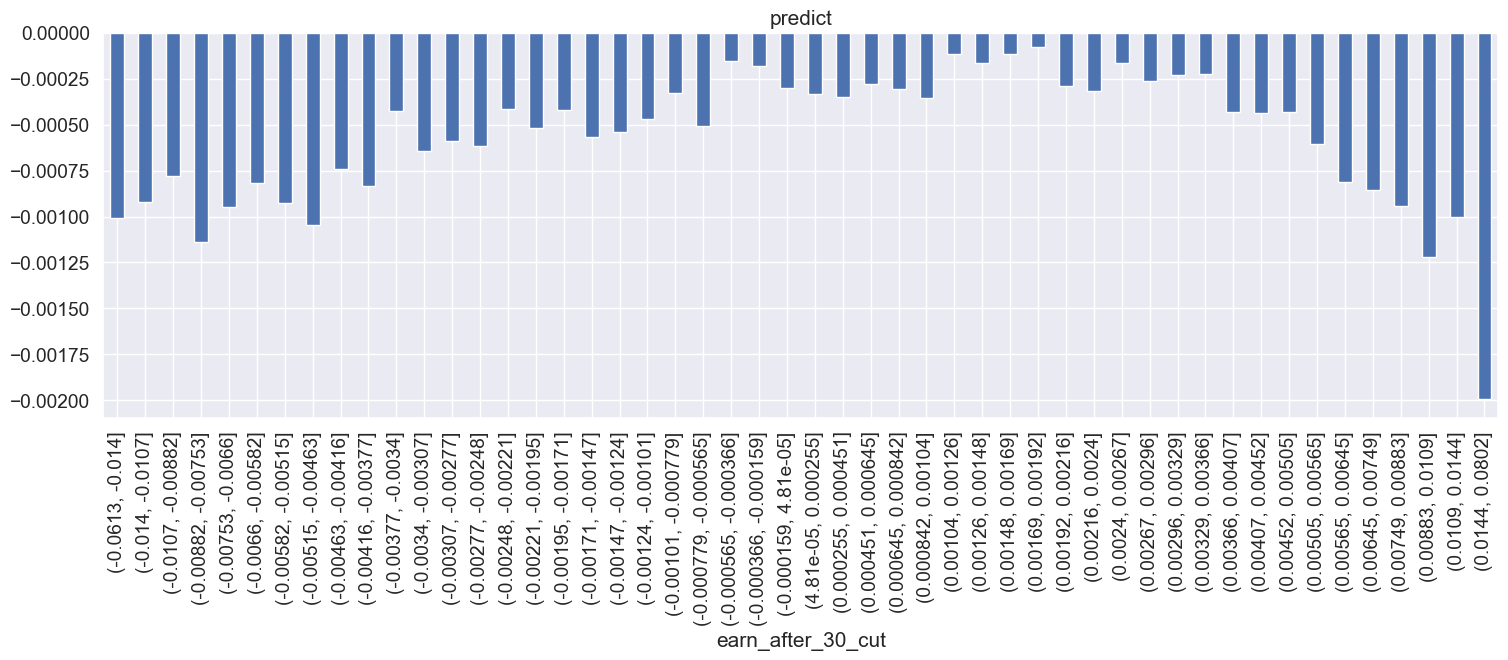

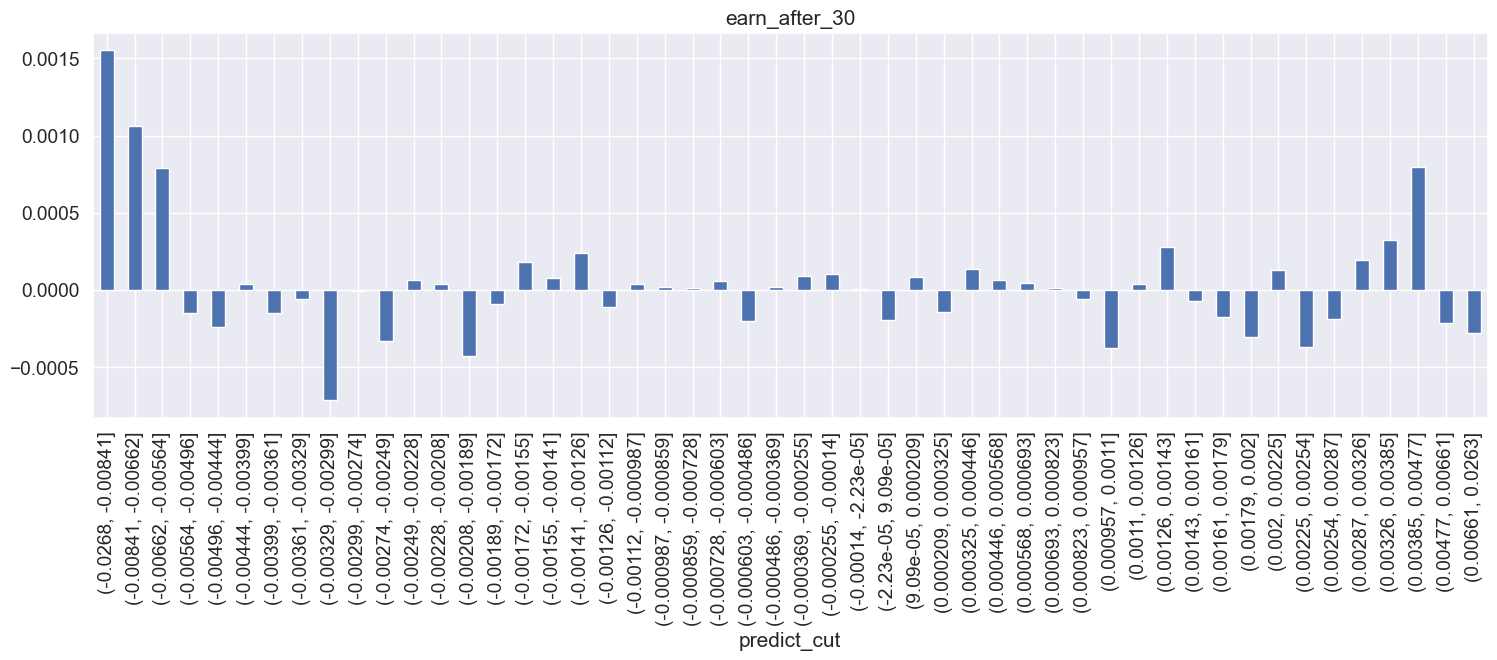

In [ ]:
import matplotlib.pyplot as plt

def plt_A_B(df_data, idx_A, idx_B, bias=0):
    plt.figure(figsize=(18,5))
    (df_data.groupby(idx_A)[idx_B].mean() - bias).plot.bar()
    plt.title(idx_B)
    plt.show()

def plt_point_A_B(df_data, idx_A, idx_B):
    df_data.plot(kind='scatter', x=idx_A, y=idx_B, figsize=(18,5))

test_df = full_buy.iloc[len(y_train):, :].copy()
test_df["predict"] = predictions_xgb
test_df[target_name + '_cut'] = pd.qcut(test_df[target_name], 50, duplicates='drop')
test_df['predict' + '_cut'] = pd.qcut(test_df['predict'], 50, duplicates='drop')

plt_A_B(test_df, target_name + '_cut', 'predict', 0)
plt_A_B(test_df, 'predict' + '_cut', target_name, 0)
# test_df.head()

+ __画 A 与 B 的箱体图__

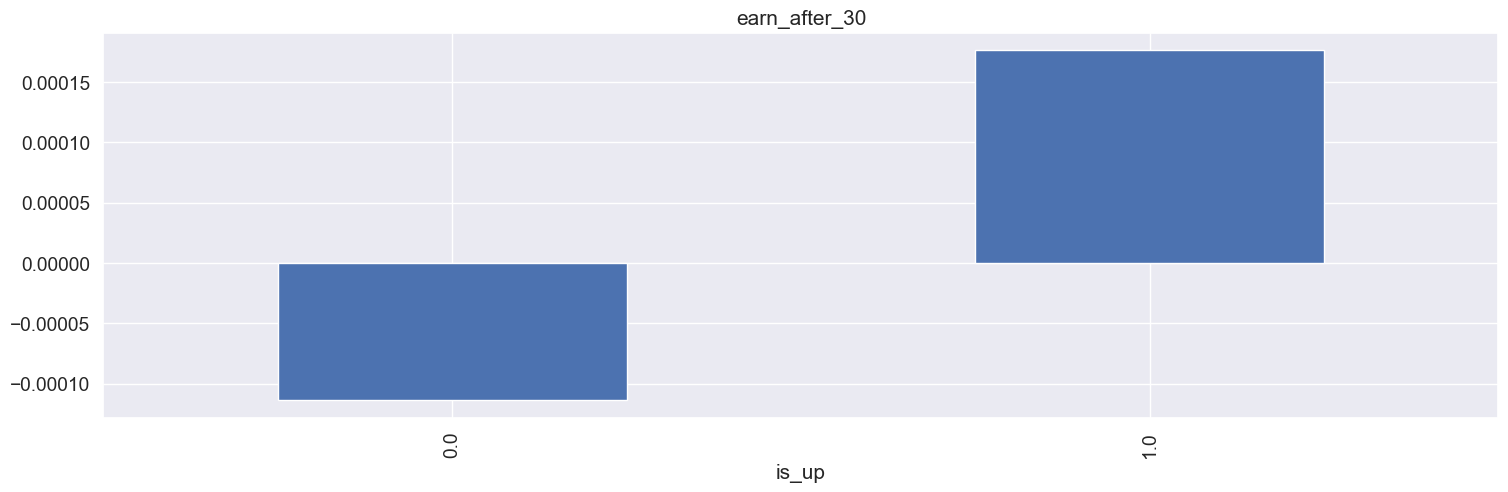

In [ ]:
def plt_box_A_B(df_data, idx_A, idx_B):
    plt.figure(figsize=(18,5))
    sns.boxplot(x=idx_A, y=idx_B, data=df_data)
    sns.stripplot(x=idx_A, y=idx_B, data=df_data)
    plt.title(idx_B)
    plt.show()


# plt_box_A_B(test_df, target_name + '_cut', 'predict')
plt_A_B(test_df, 'is_up', target_name)

## 预测与实际结果分布关系

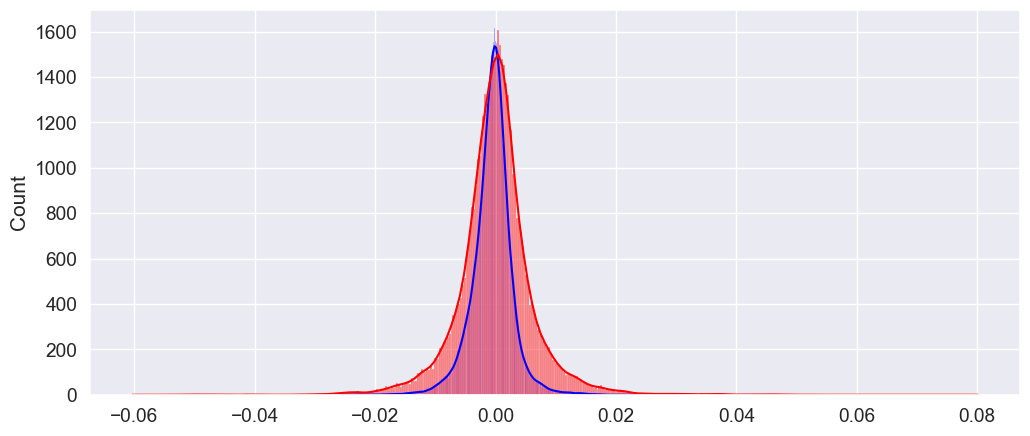

In [ ]:
import seaborn as sns

def result_plot(pred, truth):
    plt.figure(figsize=(12,5))
    sns.histplot(pred, kde=True, color="blue")
    # plt.title("Predict")
    # plt.xlabel('yield', fontsize=12)

    # plt.show()
    # plt.figure(figsize=(12,5))
    sns.histplot(truth, kde=True, color="red")
    # plt.title("Ground truth")
    plt.show()
    
result_plot(predictions_xgb, y_test)

In [ ]:
l = sum(y_test>0.01)
print(l)
s = sum(y_test<-0.01)
print(s)
print((l+s) / len(y_test))

2357
2309
0.09376067517331457
